In [16]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [17]:

class QLearning:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        # 初始Q
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.gamma = gamma
        self.alpha = alpha # 学习率
        self.epsilon = epsilon # 贪婪策略中的参数
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if(self.Q_table[state, i] == Q_max):
                a[i] = 1
        return a
    def update(self, s0, a0, r, s1):
        # 这是Q_table 距离期望值的差距
        td_error = r + self.gamma * self.Q_table[s1].max() - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

In [18]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 6251.01it/s, episode=500, return=-13.000]


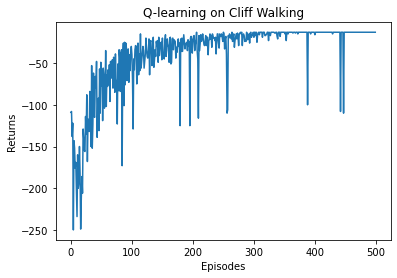

Q-learning算法最终收敛得到的策略为：
oo<o ooo> ooo> ooo> ooo> oo<o ooo> ooo> ooo> ovoo ovoo ovoo 
^ooo ooo> ooo> ooo> oo<o ooo> ooo> ooo> ^ooo ovoo ovoo ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [23]:
np.random.seed(0)
epsilon = 0.01
alpha = 0.1
gamma = 0.7
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500 #智能体在环境中运行的序列的数量


return_list = []

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])